In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA

In [7]:
!pip install GEOparse
import GEOparse

### Step 1: Import Libraries  
We import the necessary libraries for handling gene expression data, performing statistics, and visualization.  
- `GEOparse` → to download GEO datasets  
- `pandas`, `numpy` → data handling  
- `matplotlib`, `seaborn` → visualization  
- `scipy` → statistical tests  
- `sklearn` → PCA analysis  

In [8]:
print("Downloading GSE5281 dataset...")
gse = GEOparse.get_GEO("GSE5281", destdir="./")

# Expression matrix
expression_df = gse.pivot_samples('VALUE')
expression_df = expression_df.apply(pd.to_numeric, errors='coerce')
expression_df = expression_df.dropna(axis=0, how='any')
print("Expression data shape:", expression_df.shape)

30-Sep-2025 19:21:35 DEBUG utils - Directory ./ already exists. Skipping.
DEBUG:GEOparse:Directory ./ already exists. Skipping.
30-Sep-2025 19:21:35 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE5nnn/GSE5281/soft/GSE5281_family.soft.gz to ./GSE5281_family.soft.gz
INFO:GEOparse:Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE5nnn/GSE5281/soft/GSE5281_family.soft.gz to ./GSE5281_family.soft.gz


100%|██████████| 88.6M/88.6M [00:00<00:00, 105MB/s]
30-Sep-2025 19:21:36 DEBUG downloader - Size validation passed
DEBUG:GEOparse:Size validation passed
30-Sep-2025 19:21:36 DEBUG downloader - Moving /tmp/tmp82q0_49z to /content/GSE5281_family.soft.gz
DEBUG:GEOparse:Moving /tmp/tmp82q0_49z to /content/GSE5281_family.soft.gz
30-Sep-2025 19:21:36 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE5nnn/GSE5281/soft/GSE5281_family.soft.gz
DEBUG:GEOparse:Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE5nnn/GSE5281/soft/GSE5281_family.soft.gz
30-Sep-2025 19:21:36 INFO GEOparse - Parsing ./GSE5281_family.soft.gz: 
INFO:GEOparse:Parsing ./GSE5281_family.soft.gz: 
30-Sep-2025 19:21:36 DEBUG GEOparse - DATABASE: GeoMiame
DEBUG:GEOparse:DATABASE: GeoMiame
30-Sep-2025 19:21:36 DEBUG GEOparse - SERIES: GSE5281
DEBUG:GEOparse:SERIES: GSE5281
30-Sep-2025 19:21:36 DEBUG GEOparse - PLATFORM: GPL570
DEBUG:GEOparse:PLATFORM: GPL570
/usr/local/lib/python3.

Expression data shape: (54675, 161)


### Step 2: Load Dataset  
We download **GSE5281** from GEO and build an expression matrix.  
- Convert all values to numeric  
- Drop probes with missing values  
- Print the shape of the cleaned dataset

In [9]:
meta_data = pd.DataFrame({gsm: gse.gsms[gsm].metadata for gsm in gse.gsms}).T

# Extract group info
meta_data['group'] = meta_data['characteristics_ch1'].apply(
    lambda x: "Alzheimers" if "Alzheimer" in str(x) else "Control"
)

# Align samples between expression and metadata
expression_df = expression_df.loc[:, meta_data.index]

print("Samples per group:")
print(meta_data['group'].value_counts())

Samples per group:
group
Alzheimers    87
Control       74
Name: count, dtype: int64


### Step 3: Extract Metadata  
We extract phenotype/metadata for each sample.  
- Build a DataFrame from GSM metadata  
- Label samples as **Alzheimer’s** or **Control**  
- Align expression data with metadata  
- Print group counts  

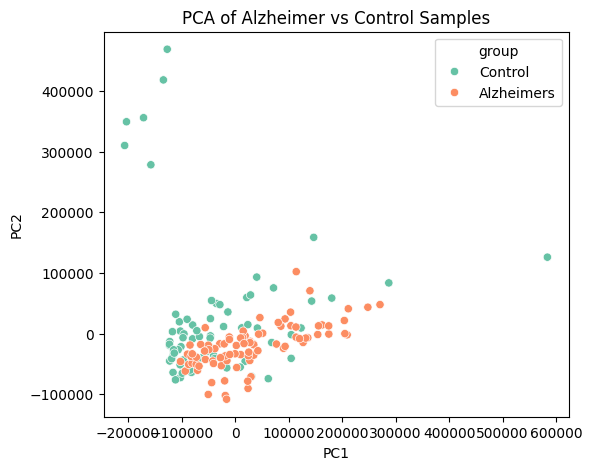

In [10]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(expression_df.T)

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=expression_df.columns)
pca_df['group'] = meta_data['group']

plt.figure(figsize=(6,5))
sns.scatterplot(x="PC1", y="PC2", hue="group", data=pca_df, palette="Set2")
plt.title("PCA of Alzheimer vs Control Samples")
plt.show()

### Step 4: PCA Visualization  
We perform **Principal Component Analysis (PCA)** on the expression data to see separation between Alzheimer’s and Control groups.  
Each point is a sample, colored by its group.  

In [11]:
alz_samples = expression_df.loc[:, meta_data[meta_data['group'] == "Alzheimers"].index]
control_samples = expression_df.loc[:, meta_data[meta_data['group'] == "Control"].index]

# Log fold change
log_fc = np.log2(alz_samples.mean(axis=1) / control_samples.mean(axis=1))

# T-test for each gene
p_values = []
for gene in expression_df.index:
    t_stat, p_val = stats.ttest_ind(alz_samples.loc[gene], control_samples.loc[gene], equal_var=False)
    p_values.append(p_val)

results_df = pd.DataFrame({
    "Gene": expression_df.index,
    "logFC": log_fc,
    "p_value": p_values
})
results_df['adj_pval'] = results_df['p_value'] * len(results_df)  # Bonferroni correction
results_df = results_df.sort_values("p_value")

print("\nTop Differentially Expressed Genes:")
print(results_df.head(20))


Top Differentially Expressed Genes:
                    Gene     logFC       p_value      adj_pval
ID_REF                                                        
227404_s_at  227404_s_at -1.449986  6.599968e-19  3.608533e-14
230392_at      230392_at  1.463896  4.776116e-18  2.611341e-13
238558_at      238558_at  1.416735  2.861973e-17  1.564784e-12
227084_at      227084_at  1.544356  3.686969e-17  2.015850e-12
237768_x_at  237768_x_at  1.308841  9.497586e-17  5.192805e-12
242829_x_at  242829_x_at  1.318671  1.596882e-16  8.730954e-12
203122_at      203122_at -1.113865  3.149916e-16  1.722217e-11
244197_x_at  244197_x_at  1.129402  6.816775e-16  3.727072e-11
230656_s_at  230656_s_at -1.646064  7.511715e-16  4.107030e-11
234762_x_at  234762_x_at  1.327976  8.877313e-16  4.853671e-11
242239_at      242239_at  1.355543  1.382813e-15  7.560530e-11
220796_x_at  220796_x_at  1.424474  1.400345e-15  7.656388e-11
243442_x_at  243442_x_at  1.200798  1.788807e-15  9.780304e-11
244778_x_at  24477

### Step 5: Differential Expression Analysis  
We perform statistical testing between Alzheimer’s and Control groups.  
- Compute **log2 fold change** between groups  
- Run **t-tests** per gene  
- Apply **Bonferroni correction** for multiple testing  
- Display the top 20 most significant genes

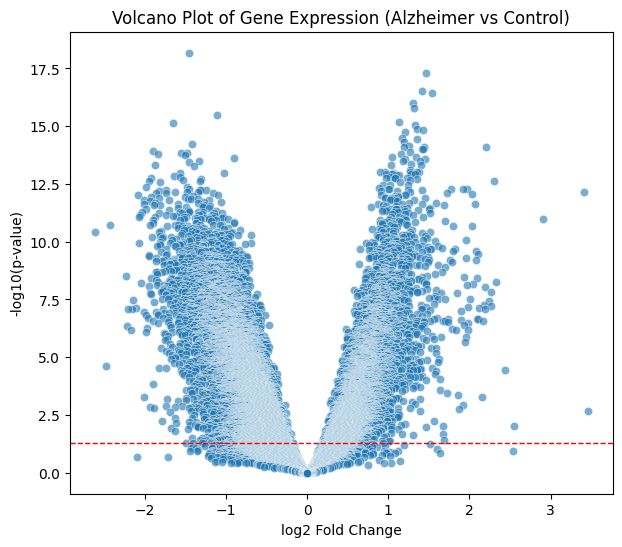

In [12]:
plt.figure(figsize=(7,6))
sns.scatterplot(
    x=results_df['logFC'],
    y=-np.log10(results_df['p_value']),
    alpha=0.6
)
plt.axhline(-np.log10(0.05), color="red", linestyle="--", linewidth=1)
plt.xlabel("log2 Fold Change")
plt.ylabel("-log10(p-value)")
plt.title("Volcano Plot of Gene Expression (Alzheimer vs Control)")
plt.show()

### Step 6: Volcano Plot  
We visualize differential expression results in a volcano plot:  
- X-axis = log2 fold change  
- Y-axis = -log10(p-value)  
- Red dashed line shows the significance threshold (p < 0.05).  